In [48]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Activation
from keras.layers import Dropout
import pickle
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [34]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec  6 19:41:37 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.103                Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  | 00000000:01:00.0  On |                  N/A |
| N/A   54C    P8               8W /  95W |   3840MiB /  4096MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [35]:
subjectList = pd.read_csv('participantID1.csv', header=None) # import the number participant IDs without the header
numSubjects = subjectList.count()[0]

subjectAlias = np.linspace(1,numSubjects,numSubjects).tolist()
outerSubjectAlias = subjectAlias
trialNames = ['NN','YN','NY','YY'] # NN = NNL + NNH, YN = YNL + YNH, NY = NYL + NHH, YY = YYL + YYH

In [36]:
with open('trajectoryDataFrame_win10.pkl', 'rb') as file:
    # Call load method to deserialze
    trajectoryDataFrame = pickle.load(file)
with open('outputDataFrame_win10.pkl', 'rb') as file:
    # Call load method to deserialze
    outputDataFrame = pickle.load(file)

In [37]:
subjectList = pd.read_csv('participantID1.csv', header=None) # import the number participant IDs without the header
numSubjects = subjectList.count()[0]

subjectAlias = np.linspace(1,numSubjects,numSubjects).tolist()
outerSubjectAlias = subjectAlias
trialNames = ['NN','YN','NY','YY'] # NN = NNL + NNH, YN = YNL + YNH, NY = NYL + NHH, YY = YYL + YYH


In [38]:
# dropoutRate,LSTM1, LSTM2,numDenseLayers,features,seq_length, numClasses

parameterSpace = []

# Full parameter set
dropOutRates = 0.3
firstLSTMNodes = 128
secondLSTMNodes = 64
numDenseLayers = 2
miniBatch = 64
numEpochs = 100
featureCombo = [['speed','thetaDot']]
#featureCombo = [['speed','thetaDot','cumulativeSum','height']]

In [39]:
def assignUserOutput(dataFrameData, requiredSubjects):
    requiredData = dataFrameData.loc[requiredSubjects].to_numpy()
    return requiredData

def assignUserTraj(dataFrameData, requiredSubjects, featureCombo, requiredFeatureCombo):
    requiredData = np.array([])
    for i in range(len(trajectoryDataFrame)):
        temp = dataFrameData[i].loc[requiredSubjects,featureCombo[requiredFeatureCombo]].to_numpy()
        temp = temp.reshape(temp.shape[0],1,temp.shape[1])
        if i == 0:
            requiredData = temp
        if i != 0 :
            requiredData = np.append(requiredData,temp, axis=1)
    return requiredData


def lstmModel(dropoutRate, LSTM1, LSTM2, numDenseLayers, features, seq_length, numClasses):
    init_learning_rate = 0.0001
    model = Sequential()
    #model.add(GaussianNoise(0.03,input_shape=(seq_length,features)))
    model.add(LSTM(LSTM1,input_shape=(seq_length,features),return_sequences=True)) # True = many to many
    model.add(LSTM(LSTM2,input_shape=(seq_length,features),return_sequences=False)) # True = many to many
    #model.add(LSTM(LSTM1,input_shape=(seq_length,features),return_sequences=False)) # True = many to many
    model.add(Dropout(0.1))
    model.add(Dense(16, activation='LeakyReLU'))
    model.add(Dropout(0.1))
    model.add(Dense(16, activation='tanh'))
    model.add(Dropout(0.1))
    model.add(Dense(16, activation='LeakyReLU'))
    model.add(Dropout(0.1))
    model.add(Dense(16, activation='tanh'))
    model.add(Dense(numClasses,kernel_initializer='normal',activation='softmax'))
    #optimizer = tf.keras.optimizers.Adam(learning_rate=init_learning_rate, weight_decay=decay_rate)
    optimizer = tf.keras.optimizers.Adam(learning_rate=init_learning_rate)
    #model.compile(loss='categorical_crossentropy',optimizer =optimizer,metrics=['accuracy'])
    #model.compile(loss='binary_crossentropy',optimizer =optimizer,metrics=['accuracy'])  
    model.compile(loss='BinaryCrossentropy',optimizer =optimizer,metrics=['accuracy'])
    return model

In [40]:
trainFraction = 0.9

numTrainData = int(trainFraction*len(outerSubjectAlias))
numTestData = len(outerSubjectAlias) - numTrainData
trainSubjects = outerSubjectAlias[0:numTrainData]
testSubjects = outerSubjectAlias[len(trainSubjects):len(outerSubjectAlias)]



trainTrajData = assignUserTraj(trajectoryDataFrame,trainSubjects, featureCombo, 0)
trainOutputData = assignUserOutput(outputDataFrame,trainSubjects)

testTrajData = assignUserTraj(trajectoryDataFrame,testSubjects, featureCombo, 0)
testOutputData = assignUserOutput(outputDataFrame,testSubjects)

features = trainTrajData.shape[2]
seq_length = trainTrajData.shape[1]
numClasses = trainOutputData.shape[1]

In [41]:
mlModel = lstmModel(dropOutRates, firstLSTMNodes, secondLSTMNodes, numDenseLayers, features, seq_length, numClasses)
history = mlModel.fit(trainTrajData,trainOutputData,epochs=200,batch_size=128,validation_data=(testTrajData, testOutputData),verbose=1)

Epoch 1/200
32/32 [==============================] - 7s 80ms/step - loss: 0.6870 - accuracy: 0.2183 - val_loss: 0.6784 - val_accuracy: 0.1672
Epoch 2/200
32/32 [==============================] - 2s 54ms/step - loss: 0.6704 - accuracy: 0.2254 - val_loss: 0.6587 - val_accuracy: 0.1906
Epoch 3/200
32/32 [==============================] - 2s 57ms/step - loss: 0.6505 - accuracy: 0.2603 - val_loss: 0.6369 - val_accuracy: 0.2508
Epoch 4/200
32/32 [==============================] - 2s 62ms/step - loss: 0.6317 - accuracy: 0.2829 - val_loss: 0.6182 - val_accuracy: 0.2274
Epoch 5/200
32/32 [==============================] - 2s 63ms/step - loss: 0.6153 - accuracy: 0.2933 - val_loss: 0.6043 - val_accuracy: 0.2274
Epoch 6/200
32/32 [==============================] - 2s 57ms/step - loss: 0.6037 - accuracy: 0.2952 - val_loss: 0.5937 - val_accuracy: 0.2274
Epoch 7/200
32/32 [==============================] - 2s 64ms/step - loss: 0.5939 - accuracy: 0.3065 - val_loss: 0.5855 - val_accuracy: 0.2274
Epoch 

In [49]:
#Predict
y_prediction = mlModel.predict(testTrajData)
y_test = testOutputData

10/10 [==============================] - 0s 40ms/step


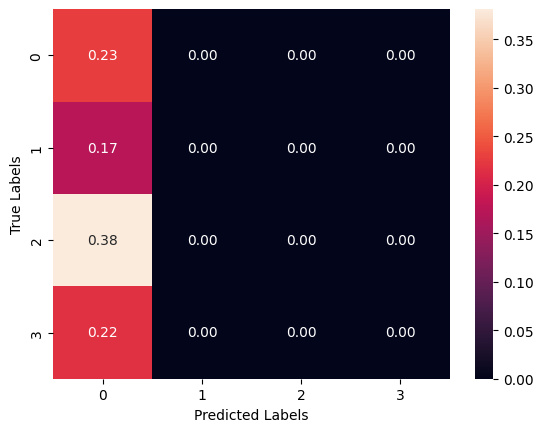

In [50]:
y_prediction=np.argmax(y_prediction, axis=-1)
y_test=np.argmax(y_test, axis=-1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction,normalize='pred')
ax = sns.heatmap(result, annot=True, fmt=".2f")
#ax.set_xticklabels(trialNames)
#ax.set_yticklabels(trialNames)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

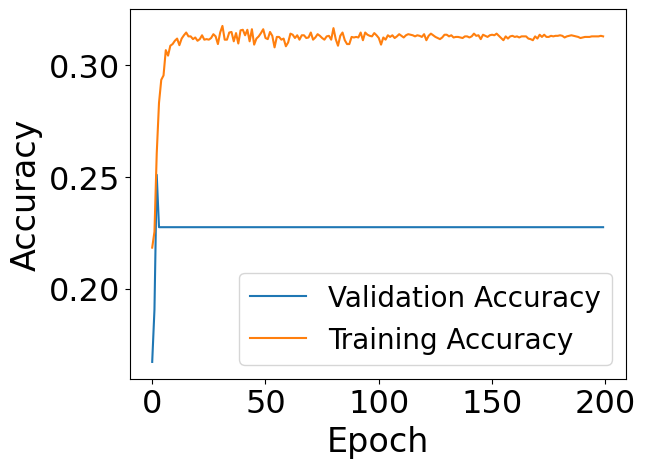

In [51]:
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Accuracy', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.legend(fontsize=20)

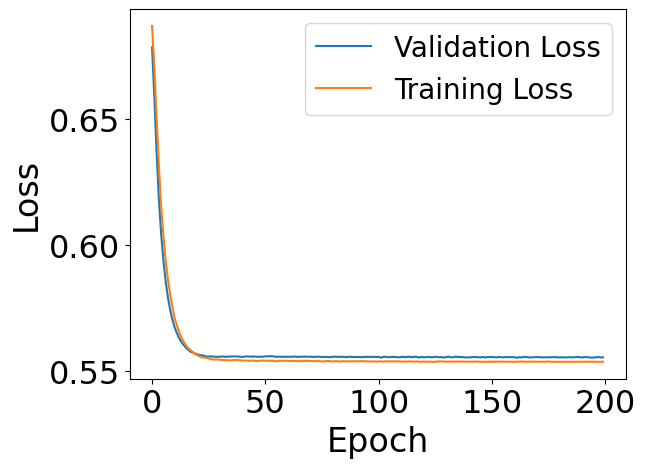

In [52]:
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Loss', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.legend(fontsize=20)